In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv("movie_dataset.csv")

# Initial exploration
print(df.head())
print(df.info())

# Drop unnecessary columns
df = df.drop(['id', 'overview'], axis=1)

# Handle missing values
df = df.dropna()

# Convert release_date to datetime and extract year
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_year'] = df['release_date'].dt.year
df = df.drop(columns=['release_date'])

# Split genres into separate columns and encode them
df['genres'] = df['genres'].str.split(',')
all_genres = df['genres'].explode().str.strip().unique()
genre_to_number = {genre: idx for idx, genre in enumerate(all_genres)}
df['primary_genre'] = df['genres'].apply(lambda x: genre_to_number[x[0].strip()])
df['secondary_genre'] = df['genres'].apply(lambda x: genre_to_number[x[1].strip()] if len(x) > 1 else -1)

# Drop the original genres column
df = df.drop(columns=['genres'])

# Filter dataset to only include movies in English
df = df[df['original_language'] == 'en']
df = df.drop(columns=['original_language'])

# Filter to movies with vote_average >= 6 and released after 1970
df = df[df['vote_average'] >= 6]
df = df[df['release_year'] >= 1970]

# Check for NaN values and handle them
print(df.isna().sum())
df = df.dropna()

# Display the cleaned dataset
print(df.head())


    id                     title release_date               genres  \
0  278  The Shawshank Redemption   1994-09-23         Drama, Crime   
1  238             The Godfather   1972-03-14         Drama, Crime   
2  240     The Godfather Part II   1974-12-20         Drama, Crime   
3  424          Schindler's List   1993-12-15  Drama, History, War   
4  389              12 Angry Men   1957-04-10                Drama   

  original_language                                           overview  \
0                en  Framed in the 1940s for the double murder of h...   
1                en  Spanning the years 1945 to 1955, a chronicle o...   
2                en  In the continuing saga of the Corleone crime f...   
3                en  The true story of how businessman Oskar Schind...   
4                en  The defense and the prosecution have rested an...   

   popularity  vote_count  vote_average  
0     124.582       26066         8.703  
1     199.537       19757         8.695  
2     12

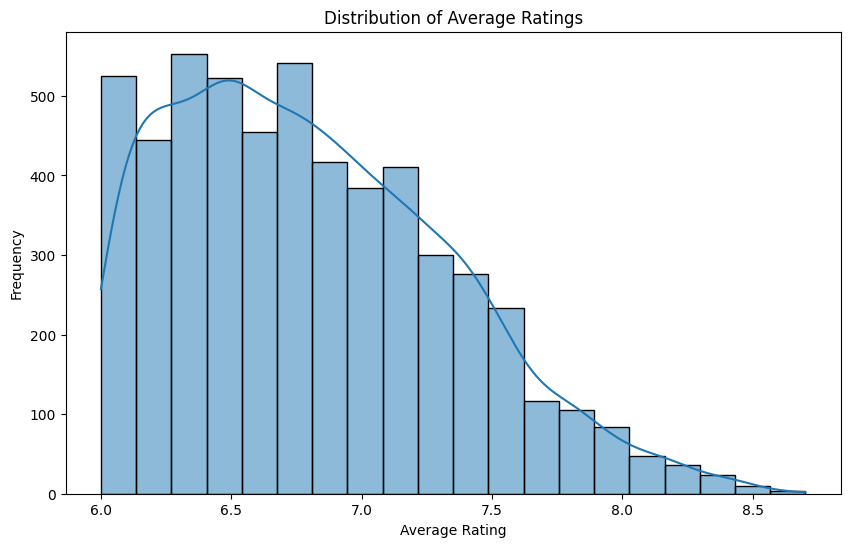

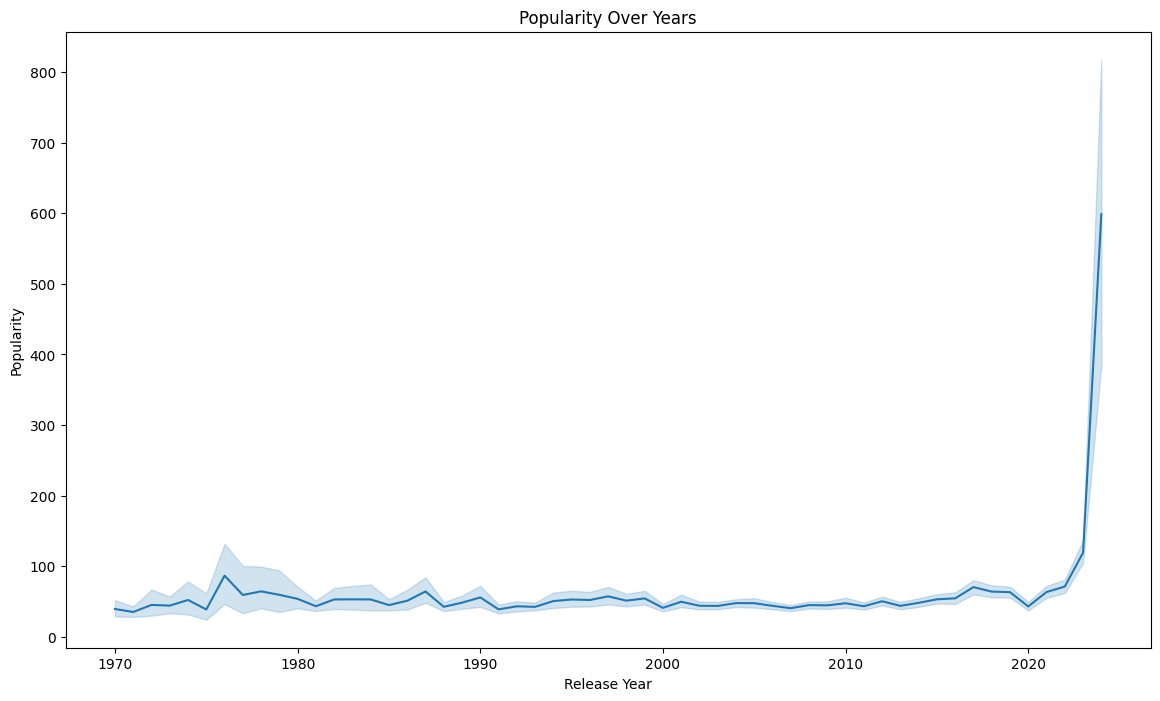

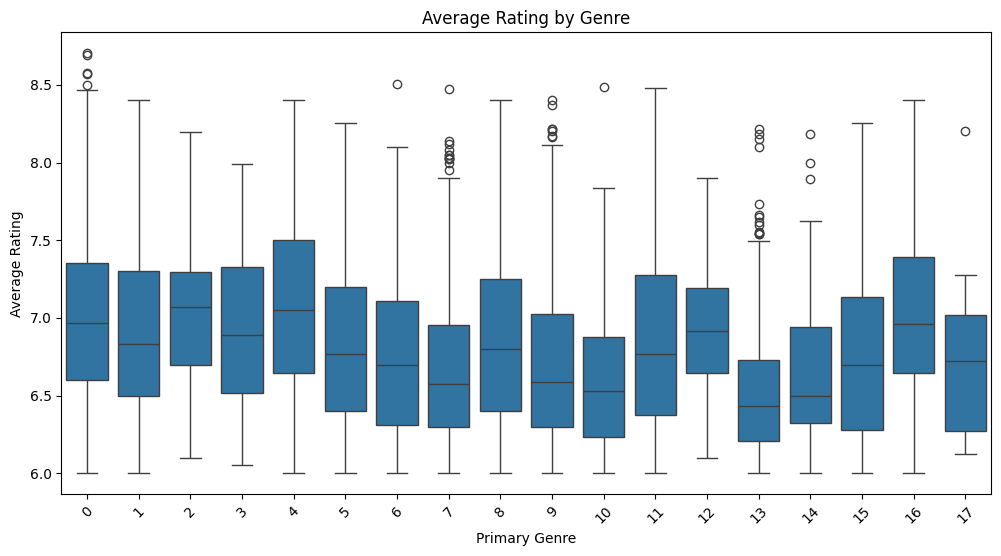

In [13]:
# Distribution of average ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['vote_average'], bins=20, kde=True)
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# Popularity over the years
plt.figure(figsize=(14, 8))
sns.lineplot(x='release_year', y='popularity', data=df)
plt.title('Popularity Over Years')
plt.xlabel('Release Year')
plt.ylabel('Popularity')
plt.show()

# Average rating by genre
plt.figure(figsize=(12, 6))
sns.boxplot(x='primary_genre', y='vote_average', data=df)
plt.title('Average Rating by Genre')
plt.xlabel('Primary Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()


Mean Squared Error: 0.18949768104291798


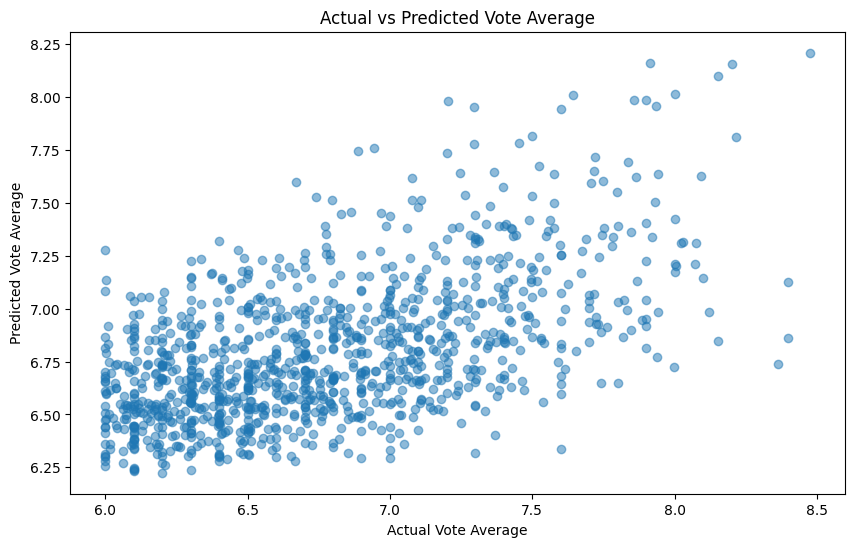

In [14]:
# Features and target variable
features = df[['vote_count', 'release_year', 'primary_genre']]
target = df['vote_average']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=32)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the KNN regressor model
knn_reg = KNeighborsRegressor(n_neighbors=11)
knn_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Scatter plot of actual vs predicted ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Vote Average')
plt.ylabel('Predicted Vote Average')
plt.title('Actual vs Predicted Vote Average')
plt.show()


99
vote_count       0
release_year     0
primary_genre    0
dtype: int64 vote_count       0
release_year     0
primary_genre    0
dtype: int64
0 0
Accuracy: 0.7170686456400742
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       725
           1       0.57      0.42      0.49       335
           2       0.33      0.17      0.22        18

    accuracy                           0.72      1078
   macro avg       0.56      0.49      0.51      1078
weighted avg       0.70      0.72      0.70      1078



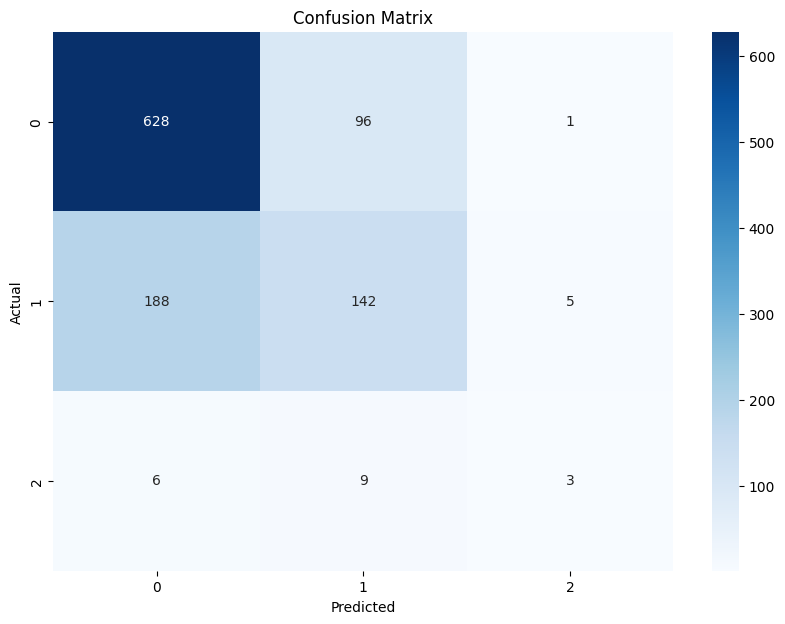

In [16]:
# Convert ratings to categories (e.g., 6-7, 7-8, 8-9, etc.)
df['rating_category'] = pd.cut(df['vote_average'], bins=[6, 7, 8, 9, 10], labels=[0, 1, 2, 3])

# Check for NaN values in the new category column
print(df['rating_category'].isna().sum())
df = df.dropna(subset=['rating_category'])

# Features and target variable
features = df[['vote_count', 'release_year', 'primary_genre']]
target = df['rating_category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=32)

# Check for NaN values in the split data
print(np.isnan(X_train).sum(), np.isnan(X_test).sum())
print(y_train.isna().sum(), y_test.isna().sum())

# Standardize the features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the KNN classifier model
knn_clf = KNeighborsClassifier(n_neighbors=7)
knn_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
